You will need cuml for this--you can of course cluster embeddings with `sklearn` or other libraries, but for this project we used cuml because of its relatively fast speed.

See: [https://docs.rapids.ai/install#selector](https://docs.rapids.ai/install#selector) for instructions on how to install cuml.

For the 24.6 version of the NVIDIA RAPIDS suite (which cuml is a component of), here is the install from the selector:

```
pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cuml-cu12==24.6.*
```

The code in this notebook assumes you have generated embeddings from a trained model; here we'll use embeddings from the model we trained on the ABC AIBS MERFISH data. To download this data see the script in `scripts/training/download_aibs.sh` or visit the ABC Atlas website [https://portal.brain-map.org/atlases-and-data/bkp/abc-atlas](https://portal.brain-map.org/atlases-and-data/bkp/abc-atlas).

This is minimal code to perform the clustering with cuml and then to visualize it. Because the number of clusters can be increased to relatively high numbers (1000) there is also some code to use colorcet to generate a colormap that can help visualize the clusters across the brain. The colormap is generated and shuffled to make it marginally less likely two nearby regions are similarly colored but it is difficult to ensure this and we didn't implement any strategies/heuristics to solve the coloring problem, which seemed complex.

In [6]:
import random
import numpy as np
import seaborn as sns
import cuml
import matplotlib.pyplot as plt
import colorcet
import pandas as pd
import anndata as ad

In [3]:
import torch

x = torch.load(
    "/home/ajl/work/d2/code/mousebrain/clustering/embeddings/temp-for-2mmc/2mmc_epoch39_all-cat-sm40_rad17.pth"
).numpy()

# x = np.load('embeds.npy')

In [4]:
nclust = 1000
n_init = 1
max_iter = 500
oversampling_factor = 3
clusterer = cuml.KMeans(
    n_clusters=nclust,
    n_init=n_init,
    max_iter=max_iter,
    oversampling_factor=oversampling_factor,
	random_state=2332 # default is 0 
)

In [5]:
labels = clusterer.fit_predict(x)

In [8]:
df = pd.read_csv(
    "/home/ajl/work/d1/abc/metadata/MERFISH-C57BL6J-638850-CCF/20231215/cell_metadata_with_parcellation_annotation.csv"
)
adata = ad.read_h5ad('/home/ajl/work/d1/abc/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850-log2.h5ad')

# download from Allen Brain Cell S3 bucket

# df = pd.read_csv('/abc/metadata/MERFISH-C57BL6J-638850-CCF/20231215/cell_metadata_with_parcellation_annotation.csv')
# adata = ad.read_h5ad('/abc/expression_matrices/MERFISH-C57BL6J-638850/20230630/C57BL6J-638850-log2.h5ad')

In [9]:
df = df[df.cell_label.isin(adata.obs.index)]

In [10]:
colormap = sns.color_palette(colorcet.glasbey, n_colors=clusterer.n_clusters)

random.Random(2332).shuffle(colormap)

# if you used our embedding generation script then the embeddings will need to be sorted
# because they are generated on a per-section basis
# if you did it all at once (which is fine, but not recommended if you have a small amt of 
# memory), then you can skip this step
output_reordered = []
for group, groupby in df.groupby('brain_section_label'):
    output_reordered.append(groupby)
    
df = pd.concat(output_reordered)


df['spatial_cluster'] = labels
df['color'] = df['spatial_cluster'].map(colormap.__getitem__)

In [28]:
df['color'].head().to_list() # these are RGB codes 

[(0.8941176470588236, 0.3215686274509804, 1.0),
 (0.5098039215686274, 0.00392156862745098, 0.8117647058823529),
 (0.8941176470588236, 0.3215686274509804, 1.0),
 (0.5098039215686274, 0.00392156862745098, 0.8117647058823529),
 (0.5098039215686274, 0.00392156862745098, 0.8117647058823529)]

In [18]:
def tissue_section_plot(
    slice_name: str,
    df: pd.DataFrame,
    s: float = 2.5,
    xbounds = (0.2, 10.7),
    ybounds = (9, 2),
    axis: bool = False,
    title: str = None
):
    section = df[df.brain_section_label == slice_name]

    fig, axs = plt.subplots(1, figsize=(6.4, 4.8))
    g = plt.scatter(
        x=section.x_reconstructed,
        y=section.y_reconstructed,
        s=s,
        c=section.color,
        edgecolors="black",
        linewidths=0.05,
        zorder=10,
        alpha=1,
    )

    if xbounds is not None:
        axs.set_xlim(*xbounds)
    if ybounds is not None:
        axs.set_ylim(*ybounds)
    if not axis:
        axs.axis("off")
    if title is not None:
        axs.set_title(title)

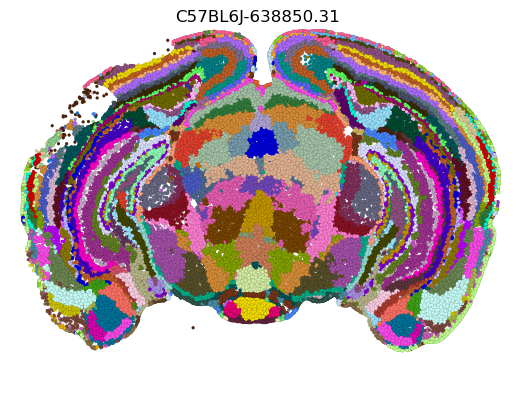

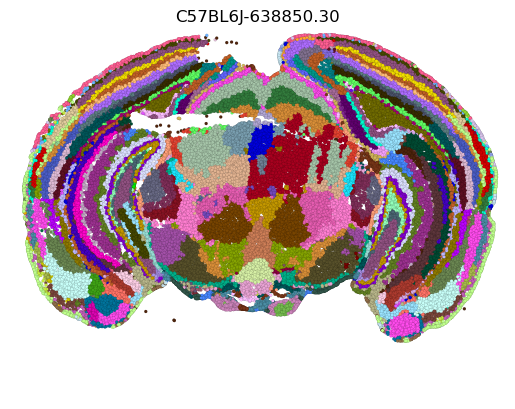

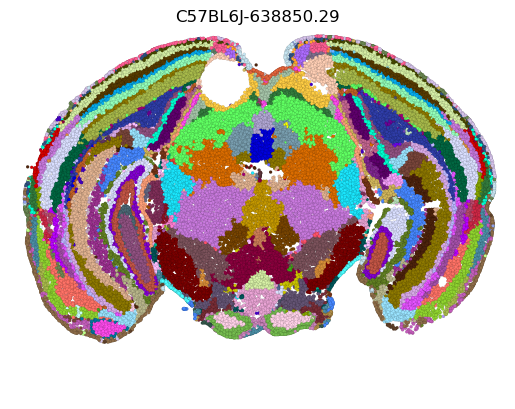

In [20]:
tissue_sections = ['C57BL6J-638850.31', 'C57BL6J-638850.30', 'C57BL6J-638850.29']
for section in tissue_sections:
	tissue_section_plot(section, df, s=5, title=section)
